## Description
- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
- - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals
- Evaluation

## Evaluation
- 자전거 대여량을 예측하는 문제다 듀란!
- 분류와 회귀중 회귀와 관련 된 문제이기 때문이다 듀란! 

In [1]:
## import pandas as pd
from datetime import datetime
import pandas as pd
import time
import numpy as np
import re
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats
# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
df_train = pd.read_csv('./data/bikesharing_train.csv',parse_dates=["datetime"],encoding = 'utf-8')
df_train.shape

(10886, 12)

In [3]:
df_test = pd.read_csv("./data/bikesharing_test.csv", parse_dates=["datetime"])
df_test.shape

(6493, 9)

### datetime 피쳐값을 년,월,시간으로 뽀개기

In [4]:
df_train["year"] = df_train["datetime"].dt.year
df_train["month"] = df_train["datetime"].dt.month
df_train["day"] = df_train["datetime"].dt.day
df_train["hour"] = df_train["datetime"].dt.hour
df_train["dayofweek"] = df_train["datetime"].dt.dayofweek
df_train.shape

(10886, 17)

In [5]:
df_test["year"] = df_test["datetime"].dt.year
df_test["month"] = df_test["datetime"].dt.month
df_test["day"] = df_test["datetime"].dt.day
df_test["hour"] = df_test["datetime"].dt.hour
df_test["dayofweek"] = df_test["datetime"].dt.dayofweek
df_test.shape

(6493, 14)

In [6]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dayofweek'],
      dtype='object')

In [7]:
df_test.columns
#'casual', 'registered', 'count'가 없다.

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'dayofweek'],
      dtype='object')

In [8]:
# df_train.columns
# df_train.info()

## train data 상관계수를 알아보자 듀란!

In [9]:
# # 모든 feature값의 상관계수 알기 : 별... 상관 없다.... 
# df_train.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('tab20c'), axis=1)

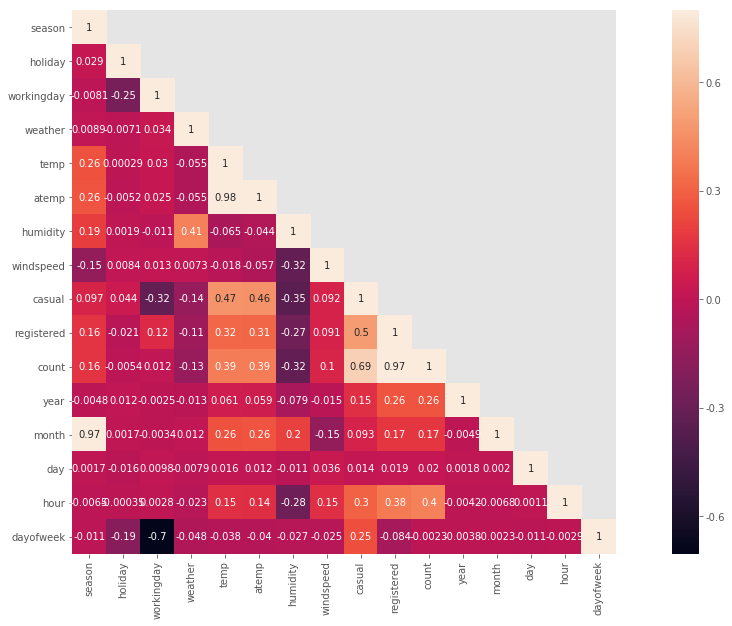

In [10]:
mask = np.array(df_train.corr()) #오른쪽 막대기듀란!
mask[np.tril_indices_from(mask)] = False #내부 네모네모즈 듀란!
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(df_train.corr(), mask=mask,vmax=.8, square=True,annot=True)

## 피쳐값 조정을 위해 모든 변수 *시.각.화* 하자구욧!!!

C:\Users\dotst\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ValueError: Could not interpret input 'minute'

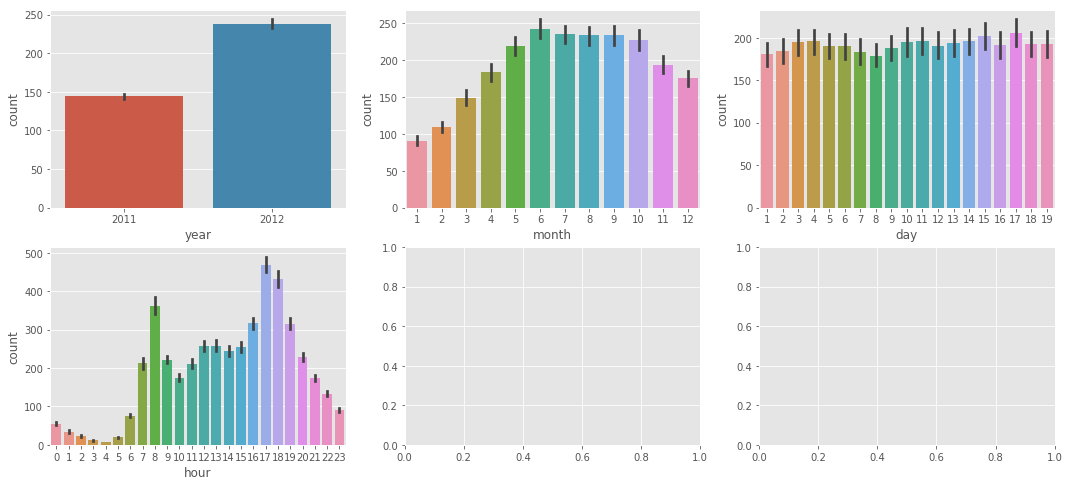

In [11]:
import seaborn as sns
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=df_train, x="year", y="count", ax=ax1)
sns.barplot(data=df_train, x="month", y="count", ax=ax2)
sns.barplot(data=df_train, x="day", y="count", ax=ax3)
sns.barplot(data=df_train, x="hour", y="count", ax=ax4)
sns.barplot(data=df_train, x="minute", y="count", ax=ax5)
sns.barplot(data=df_train, x="second", y="count", ax=ax6)

ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")

- 연도별 대여량 2011 < 2012
- 월별 대여량은 6월에 가장 많고 7~10월도 대여량이 많다. 그리고 1월에 가장 적다.
- 일별대여량은 1일부터 19일까지만 있고 나머지 날짜는 test.csv에 있다. 그래서 이 데이터는 피처로 사용하면 안 된다.
- 시간 대 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 나누어 볼 필요가 있을 것 같다.
- 분, 초도 다 0이기 때문에 의미가 없다.

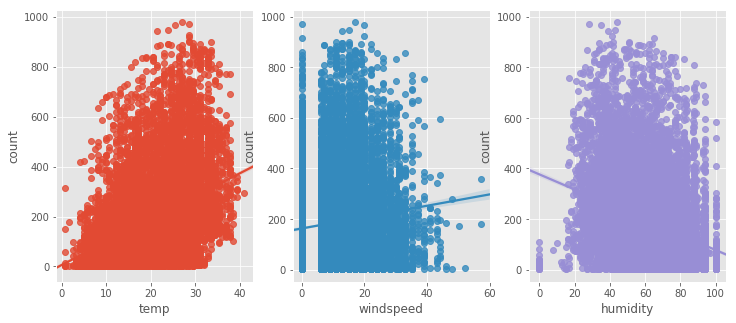

In [12]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=df_train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=df_train,ax=ax2)
sns.regplot(x="humidity", y="count", data=df_train,ax=ax3)

- 풍속의 경우 0에 숫자가 몰려 있는 것으로 보인다 듀란!
- 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해 본다.

## count값도 노답쓰.. 노답쓰...정규화가 필요하다규!
## Outliers 구해서 조지자규!

In [14]:
# trainWithoutOutliers
df_trainWithoutOutliers = df_train[np.abs(df_train["count"] - df_train["count"].mean()) <= (3*df_train["count"].std())]

print(df_train.shape) #outlier 제거 전
print(df_trainWithoutOutliers.shape) #outlier제거 후 

(10886, 17)
(10739, 17)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909612))

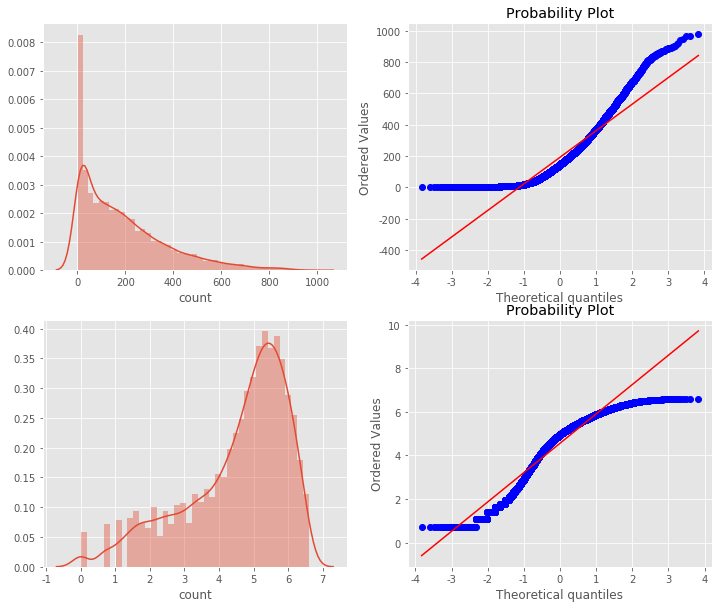

In [15]:
# count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(df_train["count"], ax=axes[0][0])
stats.probplot(df_train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(df_trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(df_trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

- count변수가 오른쪽에 치우쳐져 있다 듀란!
- 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다규
- 대안으로 outlier data를 제거하고! "count"변수에 로그를 씌워 변경해 봐도!
- 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다

In [16]:
# df_train.columns

In [17]:
# df_train.info()

In [18]:
# df_train['windspeed'].value_counts()

In [19]:
# df_train['season'].value_counts()

In [20]:
# df_train['holiday'].value_counts()

In [21]:
# df
# _train['workingday'].value_counts()

In [22]:
# df_train['weather'].value_counts()

In [23]:
# df_train['temp'].value_counts()

In [24]:
# df_train['atemp'].value_counts()

In [25]:
# df_train['humidity'].value_counts()

In [26]:
# df_train['casual'].value_counts()

In [27]:
# df_train['registered'].value_counts()

In [28]:
# tmp_wind = df_train.loc[['windspeed' == 0], 'windspeed']

## 자! 이제 풍속 0인거 조지자규 듀란

In [29]:
# 풍속이 0인것과 아닌 것의 세트를 나누어 준다듀란
trainWind0 = df_train.loc[df_train['windspeed'] == 0]
trainWindNot0 = df_train.loc[df_train['windspeed'] != 0]


testWind0 = df_test.loc[df_test['windspeed'] == 0]
testWindNot0 = df_test.loc[df_test['windspeed'] != 0]

In [30]:
len(testWind0)

867

In [31]:
del trainWind0['windspeed']
del testWind0['windspeed']

In [32]:
#windspeed 0이 아닌 모든 데이터프레임의 정규분포 값을 1313개구하다규
wind=np.random.normal(trainWindNot0['windspeed'].mean(), 1, 1313)
df_wind=pd.DataFrame(wind)
df_wind=df_wind.rename(columns={0:'windspeed'})


wind_test=np.random.normal(testWindNot0['windspeed'].mean(), 1, 867)
df_wind_test=pd.DataFrame(wind_test)
df_wind_test=df_wind_test.rename(columns={0:'windspeed'})

In [33]:
# del df_train['atemp']

In [34]:
trainWind0 = trainWind0.reset_index(drop=True)

testWind0 = testWind0.reset_index(drop=True)

### 풍속 0 을 특정값으로 넣자규!

In [35]:
df_train2 = pd.concat([trainWind0,df_wind],axis = 1)
df_test2 = pd.concat([testWind0,df_wind_test],axis = 1)

# del test['windspeed']

In [36]:
df_train2.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'casual', 'registered', 'count', 'year', 'month',
       'day', 'hour', 'dayofweek', 'windspeed'],
      dtype='object')

In [37]:
trainWindNot0.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dayofweek'],
      dtype='object')

In [39]:
df_train2 = df_train2[['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dayofweek']]

df_test2 = df_test2[['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed',
       'year', 'month', 'day', 'hour', 'dayofweek']]

## 이제 풍속값0 조진 완전한 Train Data 탄생이라규!

In [42]:
df_train3 = pd.concat([df_train2, trainWindNot0], axis=0)
df_test3 = pd.concat([df_test2, testWindNot0], axis=0)

In [69]:
df_train3.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dayofweek'],
      dtype='object')

In [70]:
df_test3.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'dayofweek'],
      dtype='object')

# 여기부터 뜯어 고쳤다 듀란!

In [44]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    df_train3[var] = df_train3[var].astype("category")
    df_test3[var] = df_test3[var].astype("category")

In [45]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [46]:
X_train = df_train3[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,13.183554,2011,0,5,0,0
1,1,1,9.02,13.635,80,12.823873,2011,1,5,0,0
2,1,1,9.02,13.635,80,14.429532,2011,2,5,0,0
3,1,1,9.84,14.395,75,16.417657,2011,3,5,0,0
4,1,1,9.84,14.395,75,15.574780,2011,4,5,0,0


In [68]:
Y_train = df_train3[['count']]
Y_train.head()

,count
0,16
1,40
2,32
3,13
4,1


In [52]:
# X_train.to_csv('./data/bike_new_train.csv')

In [ ]:
# X_test.to_csv('./data/bike_new_test.csv')

In [65]:
X_test = df_test3[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,13.635,56,13.694824,2011,1,3,0,1
1,1,1,10.66,13.635,56,15.639076,2011,2,3,0,1
2,1,2,12.30,16.665,42,14.936487,2011,12,3,0,1
3,1,1,3.28,8.335,35,14.528740,2011,13,5,0,0
4,1,1,4.92,7.575,28,15.613577,2011,15,5,0,0


In [53]:
X_test.to_csv('./data/bike_new_test.csv')

## 탠서플로우 돌리자규랑

In [63]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm_notebook

In [72]:
train = df_train3[feature_names]
train.shape()

TypeError: 'tuple' object is not callable

In [71]:
test = df_test3[feature_names]
test.shape()

TypeError: 'tuple' object is not callable

In [73]:
# train = pd.read_csv('./data/bike_new_train.csv')
# train.shape()

TypeError: 'tuple' object is not callable

In [56]:
# test = pd.read_csv('./data/bike_new_test.csv')
# test.shape

(6493, 12)

In [57]:
tf.set_random_seed(777)  # for reproducibility

# np.loadtxt('./data/test2_bike.csv', delimiter=',', dtype=np.float32)
xy = np.loadtxt('./team_project_2/basic_dataset/bike/test2_bike.csv', delimiter=',', skiprows=1, dtype=np.int32)
x_data = xy[:, 1:-1]
y_data = xy[:, [-1]]

# Make sure the shape and data are OK
print("x_data.shape : {}, \tlen(x_data) : {} \nx_data : \n{}".format(x_data.shape, len(x_data), x_data))
print("-"*25)
print("y_data.shape : {}  \ny_data : \n{}".format(y_data.shape, y_data))

# placeholders for a tensor that will be always fed.
X = tf.placeholder(tf.float32, shape=[None, 11])
Y = tf.placeholder(tf.float32, shape=[None, 1])

W1 = tf.Variable(tf.random_normal([11, 128]), name='weight')
b1 = tf.Variable(tf.random_normal([128]), name='bias')
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.random_normal([128, 128]), name='weight2')
b2 = tf.Variable(tf.random_normal([128]), name='bias2')
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W2 = tf.Variable(tf.random_normal([128, 1]))
b2 = tf.Variable(tf.random_normal([1]))

# Hypothesis
hypothesis = tf.matmul(L1, W2) + b2

# Simplified cost/loss function
cost = tf.reduce_mean(tf.square(hypothesis - Y))

# Minimize
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-5)
train = optimizer.minimize(cost)

,Unnamed: 0,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,0,1,1,9.84,14.395,81,13.183554,2011,0,5,0,0
1,1,1,1,9.02,13.635,80,12.823873,2011,1,5,0,0
2,2,1,1,9.02,13.635,80,14.429532,2011,2,5,0,0
3,3,1,1,9.84,14.395,75,16.417657,2011,3,5,0,0
4,4,1,1,9.84,14.395,75,15.574780,2011,4,5,0,0


In [58]:
test.head()

,Unnamed: 0,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,0,1,1,10.66,13.635,56,13.694824,2011,1,3,0,1
1,1,1,1,10.66,13.635,56,15.639076,2011,2,3,0,1
2,2,1,2,12.30,16.665,42,14.936487,2011,12,3,0,1
3,3,1,1,3.28,8.335,35,14.528740,2011,13,5,0,0
4,4,1,1,4.92,7.575,28,15.613577,2011,15,5,0,0


In [ ]:
# test2['temp'] =test2['temp'] / test2['temp'].max()
# test2['temp']

# test2['humidity'] =test2['humidity'] / test2['humidity'].max()
# test2['humidity']

test2['windspeed'] =test2['windspeed'] / test2['windspeed'].max()
train_total = test2

# X = X / X.max()
# X = X - X.mean(axis=1).reshape(len(X), 1)

In [ ]:
# # for i in range(len(test2['year'])):
# #     if test2['year'][i] == 2011:
# #         test2['year'][i] = 0
# #     else:
# #         test2['year'][i] = 1
# # test2['year'][0]
# # test2['year'].value_counts()

# # test2['year'].value_counts()
# test3=test2.drop(columns =['year'])
# #  df.drop(columns=['B', 'C'])
# test3.to_csv('./data/test3_bike.csv',encoding = 'utf-8')

In [ ]:
# test2.to_csv('./data/test2_bike.csv', sep=',', encoding='utf-8')

In [ ]:
# x_data = test2[['season', 'holiday', 'workingday', 'weather', 'temp',
#         'humidity', 'windspeed', 'year', 'month',
#        'day', 'hour']]
# y_data = test2[['count']]

In [ ]:
train_total.describe()

### Feature Selection
- 신호와 잡음을 구분해야 한다.
- 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [ ]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "month","year","hour"]

for var in categorical_feature_names:
    train_total[var] = train_total[var].astype("category")
    
train_total.head()

In [ ]:
feature_names = ["season", "weather", "temp", "humidity", "windspeed",
                 "year", "hour", "holiday", "workingday"]

feature_names

In [ ]:
X_train = train_total[feature_names]

print(X_train.shape)
X_train.head()